# Dutch Startup Ecosystem Analysis

**Research Question**: Why do Dutch startups struggle to scale compared to international peers?

**Data**: 48,000+ VC-backed companies (2005-2014 first funding), Crunchbase

---

## Notebook Structure
1. **Setup & Data Cleaning**
2. **EDA: Comprehensive Distributions**
3. **EDA: Cohort Analysis**
4. **Funnel Analysis**
5. **Key Findings Charts**

---

In [1]:
# === PART 1: SETUP & DATA CLEANING ===
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

# Color scheme
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b']
TECHLEAP_RED = '#D55E00'

COUNTRY_COLORS = {
    'nl': '#D55E00', 'usa': '#0072B2', 'israel': '#009E73',
    'uk': '#56B4E9', 'germany': '#E69F00', 'france': '#CC79A7',
    'gray': '#999999', 'success': '#009E73', 'failure': '#D55E00'
}

def tufte_style(ax):
    """Apply clean Tufte-style formatting to axes."""
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_color('#666666')
    ax.spines['bottom'].set_color('#666666')
    ax.tick_params(colors='#666666')
    return ax

# Create figures directory
os.makedirs('figures', exist_ok=True)

# Load data
df_raw = pd.read_csv('/Users/coendewith/techleap/investments_VC.csv', encoding='latin-1')

# Clean column names
df = df_raw.copy()
df.columns = df.columns.str.strip()
df['country_code'] = df['country_code'].str.strip()
df['market'] = df['market'].str.strip() if 'market' in df.columns else None

# Parse dates and filter to 2005-2014 cohort
df['first_funding_at'] = pd.to_datetime(df['first_funding_at'], errors='coerce')
df = df[df['first_funding_at'].notna()]
df['first_funding_year'] = df['first_funding_at'].dt.year
df_filtered = df[(df['first_funding_year'] >= 2005) & (df['first_funding_year'] <= 2014)].copy()

# Parse founded year
df_filtered['founded_year'] = pd.to_numeric(df_filtered['founded_at'].str[:4], errors='coerce')

# Clean funding columns
round_cols = ['seed', 'round_A', 'round_B', 'round_C', 'round_D']
for col in round_cols + ['funding_rounds', 'funding_total_usd']:
    if col in df_filtered.columns:
        df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce').fillna(0)

# Create derived columns
df_filtered['had_seed'] = df_filtered['seed'] > 0
df_filtered['had_series_a'] = df_filtered['round_A'] > 0
df_filtered['had_series_b'] = df_filtered['round_B'] > 0
df_filtered['had_series_c'] = df_filtered['round_C'] > 0
df_filtered['exited'] = df_filtered['status'].isin(['acquired', 'ipo'])
df_filtered['failed'] = df_filtered['status'] == 'closed'
df_filtered['operating'] = df_filtered['status'] == 'operating'

# Dutch subset
dutch = df_filtered[df_filtered['country_code'] == 'NLD'].copy()

# Country mapping
COUNTRIES = {'NLD': 'Netherlands', 'USA': 'USA', 'ISR': 'Israel', 
             'GBR': 'UK', 'DEU': 'Germany', 'FRA': 'France'}

print(f"Loaded {len(df_raw):,} companies")
print(f"Filtered dataset: {len(df_filtered):,} companies (2005-2014 first funding)")
print(f"Dutch companies: {len(dutch):,}")
print(f"\nStatus distribution:")
print(df_filtered['status'].value_counts())

Loaded 54,294 companies
Filtered dataset: 48,163 companies (2005-2014 first funding)
Dutch companies: 305

Status distribution:
status
operating    41037
acquired      3318
closed        2564
Name: count, dtype: int64


In [ ]:
# === PART 2: EDA - COMPREHENSIVE DISTRIBUTIONS ===

# Re-read funding data fresh from CSV (Part 1 corrupted funding_total_usd due to commas)
funding_fix = pd.read_csv('/Users/coendewith/techleap/investments_VC.csv', encoding='latin-1')
funding_fix.columns = funding_fix.columns.str.strip()
funding_fix['funding_total_usd'] = (funding_fix['funding_total_usd']
                                    .astype(str)
                                    .str.replace(',', '', regex=False)
                                    .str.replace(' ', '', regex=False))
funding_fix['funding_total_usd'] = pd.to_numeric(funding_fix['funding_total_usd'], errors='coerce').fillna(0)

# Merge clean funding back into df_filtered
df_filtered = df_filtered.drop(columns=['funding_total_usd'], errors='ignore')
df_filtered = df_filtered.merge(funding_fix[['permalink', 'funding_total_usd']], on='permalink', how='left')

fig, axes = plt.subplots(2, 3, figsize=(16, 10))

# Get funding data (filter out zeros and very small values)
funding_nonzero = df_filtered[df_filtered['funding_total_usd'] > 1000]['funding_total_usd']

print(f"Funding stats: min=${funding_nonzero.min():,.0f}, max=${funding_nonzero.max():,.0f}, median=${funding_nonzero.median():,.0f}")

# 1a. Raw funding distribution (log scale)
ax1 = axes[0, 0]
log_funding = np.log10(funding_nonzero)
ax1.hist(log_funding, bins=50, color=COLORS[1], alpha=0.8, edgecolor='white')
median_log = np.log10(funding_nonzero.median())
mean_log = np.log10(funding_nonzero.mean())
ax1.axvline(median_log, color=TECHLEAP_RED, linestyle='--', linewidth=2, label=f'Median: ${funding_nonzero.median()/1e6:.1f}M')
ax1.axvline(mean_log, color='green', linestyle=':', linewidth=2, label=f'Mean: ${funding_nonzero.mean()/1e6:.1f}M')
ax1.set_xlabel('Log10(Total Funding USD)')
ax1.set_ylabel('Number of Companies')
ax1.set_title('Funding Distribution (Log Scale)', fontweight='bold')
ax1.legend(fontsize=8)
ax1.set_xticks([4, 5, 6, 7, 8, 9])
ax1.set_xticklabels(['$10K', '$100K', '$1M', '$10M', '$100M', '$1B'])

# 1b. Funding percentiles
ax2 = axes[0, 1]
percentiles = [10, 25, 50, 75, 90, 95, 99]
pct_values = [funding_nonzero.quantile(p/100) / 1e6 for p in percentiles]
bars = ax2.bar([f'P{p}' for p in percentiles], pct_values, color=COLORS[3], alpha=0.8)
ax2.set_ylabel('Funding ($M)')
ax2.set_title('Funding Percentiles', fontweight='bold')
for i, v in enumerate(pct_values):
    label = f'${v:.1f}M' if v < 100 else f'${v:.0f}M'
    ax2.text(i, v + max(pct_values)*0.02, label, ha='center', fontsize=8)

# 1c. Funding rounds distribution
ax3 = axes[0, 2]
rounds_dist = df_filtered['funding_rounds'].value_counts().sort_index().head(10)
ax3.bar(rounds_dist.index, rounds_dist.values, color=COLORS[4], alpha=0.8)
ax3.set_xlabel('Number of Funding Rounds')
ax3.set_ylabel('Number of Companies')
ax3.set_title('Funding Rounds Distribution', fontweight='bold')
for idx, v in rounds_dist.items():
    pct = v / len(df_filtered) * 100
    ax3.text(idx, v + max(rounds_dist.values)*0.02, f'{pct:.0f}%', ha='center', fontsize=8)

# 1d. Status distribution (global)
ax4 = axes[1, 0]
status_counts = df_filtered['status'].value_counts()
colors_status = [COLORS[2] if s == 'operating' else COLORS[0] if s == 'acquired' else COLORS[5] for s in status_counts.index]
wedges, texts, autotexts = ax4.pie(status_counts.values, labels=status_counts.index, colors=colors_status, autopct='%1.1f%%', startangle=90)
ax4.set_title('Company Status (Global)', fontweight='bold')

# 1e. Companies by founding year
ax5 = axes[1, 1]
year_counts = df_filtered['founded_year'].value_counts().sort_index()
year_counts = year_counts[(year_counts.index >= 2000) & (year_counts.index <= 2014)]
ax5.bar(year_counts.index, year_counts.values, color=COLORS[1], alpha=0.8)
ax5.axvspan(2007, 2009, alpha=0.2, color='gray', label='2008 Crisis')
ax5.set_xlabel('Founding Year')
ax5.set_ylabel('Companies')
ax5.set_title('Companies by Founding Year', fontweight='bold')
ax5.legend()

# 1f. Top countries
ax6 = axes[1, 2]
country_counts = df_filtered['country_code'].value_counts().head(10)
colors_country = [TECHLEAP_RED if c == 'NLD' else COLORS[1] for c in country_counts.index]
ax6.barh(range(len(country_counts)), country_counts.values, color=colors_country, alpha=0.8)
ax6.set_yticks(range(len(country_counts)))
ax6.set_yticklabels(country_counts.index)
ax6.set_xlabel('Number of Companies')
ax6.set_title('Top 10 Countries', fontweight='bold')
ax6.invert_yaxis()

plt.tight_layout()
plt.savefig('figures/01_comprehensive_distributions.png', dpi=150, bbox_inches='tight')
plt.show()

print("="*70)
print("                    KEY DISTRIBUTION STATISTICS")
print("="*70)
print(f"\nFUNDING AMOUNTS (n={len(funding_nonzero):,} companies with funding > $1K)")
print(f"   Median: ${funding_nonzero.median():,.0f} (${funding_nonzero.median()/1e6:.2f}M)")
print(f"   Mean:   ${funding_nonzero.mean():,.0f} (${funding_nonzero.mean()/1e6:.2f}M)")
single_round = (df_filtered['funding_rounds'] == 1).sum()
print(f"\nFUNDING ROUNDS: {single_round/len(df_filtered)*100:.1f}% have only 1 round")

Cohort Analysis by Founding Year:
              Company_Count  Avg_Funding  Median_Funding  Total_Funding  \
founded_year                                                              
2005.0                 1407         0.36             0.0          500.0   
2006.0                 1802         0.00             0.0            0.0   
2007.0                 2324         0.39             0.0          900.0   
2008.0                 2342         0.00             0.0            0.0   
2009.0                 2975         0.10             0.0          291.0   
2010.0                 3768         0.42             0.0         1600.0   
2011.0                 4904         0.03             0.0          123.0   
2012.0                 5205         0.10             0.0          502.0   
2013.0                 4042         0.71             0.0         2865.0   
2014.0                 1467         4.13             0.0         6059.0   

              Avg_Rounds  Operating_Rate  
founded_year          

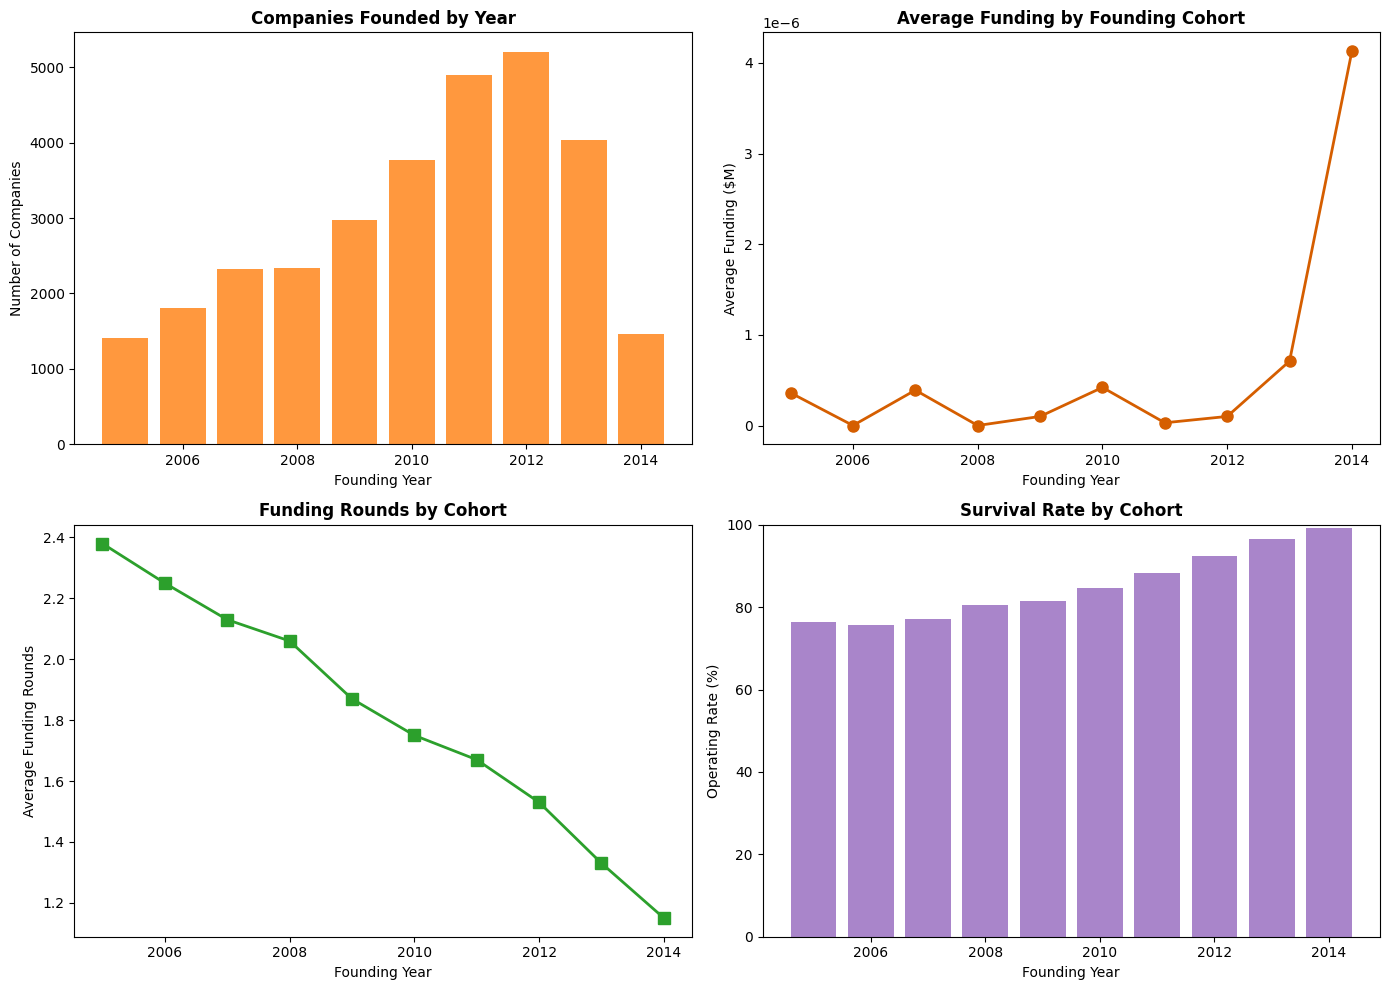

In [3]:
# === PART 3: EDA - COHORT ANALYSIS ===
# Source: legacy/task-1-analysis/analysis.ipynb

# Create cohort analysis DataFrame
cohort_analysis = df_filtered.groupby('founded_year').agg({
    'permalink': 'count',
    'funding_total_usd': ['mean', 'median', 'sum'],
    'funding_rounds': 'mean',
    'status': lambda x: (x == 'operating').mean() * 100
}).round(2)

cohort_analysis.columns = ['Company_Count', 'Avg_Funding', 'Median_Funding', 'Total_Funding', 'Avg_Rounds', 'Operating_Rate']
cohort_analysis = cohort_analysis[(cohort_analysis.index >= 2005) & (cohort_analysis.index <= 2014)]

print("Cohort Analysis by Founding Year:")
print(cohort_analysis)

# Visualization: Cohort trends
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Company count by year
ax1 = axes[0, 0]
ax1.bar(cohort_analysis.index, cohort_analysis['Company_Count'], color=COLORS[1], alpha=0.8)
ax1.set_xlabel('Founding Year')
ax1.set_ylabel('Number of Companies')
ax1.set_title('Companies Founded by Year', fontweight='bold')

# Average funding by year
ax2 = axes[0, 1]
ax2.plot(cohort_analysis.index, cohort_analysis['Avg_Funding']/1e6, 'o-', color=TECHLEAP_RED, linewidth=2, markersize=8)
ax2.set_xlabel('Founding Year')
ax2.set_ylabel('Average Funding ($M)')
ax2.set_title('Average Funding by Founding Cohort', fontweight='bold')

# Average rounds by year
ax3 = axes[1, 0]
ax3.plot(cohort_analysis.index, cohort_analysis['Avg_Rounds'], 's-', color=COLORS[2], linewidth=2, markersize=8)
ax3.set_xlabel('Founding Year')
ax3.set_ylabel('Average Funding Rounds')
ax3.set_title('Funding Rounds by Cohort', fontweight='bold')

# Operating rate by year
ax4 = axes[1, 1]
ax4.bar(cohort_analysis.index, cohort_analysis['Operating_Rate'], color=COLORS[4], alpha=0.8)
ax4.set_xlabel('Founding Year')
ax4.set_ylabel('Operating Rate (%)')
ax4.set_title('Survival Rate by Cohort', fontweight='bold')
ax4.set_ylim(0, 100)

plt.tight_layout()
plt.savefig('figures/cohort_analysis.png', dpi=150, bbox_inches='tight')
plt.show()

FUNDING FUNNEL BY COUNTRY (% reaching each stage)
             Funded  Seed  Series A  Series B  Series C  Exited      n
country                                                               
Netherlands     100  31.8      11.5       7.2       2.0     4.3    305
USA             100  24.9      19.9      12.6       7.0     8.9  28006
Israel          100  27.0      25.2      16.0       7.3     8.5    674
UK              100  30.3      13.4       7.6       3.4     5.0   2580
Germany         100  25.1      14.0       9.1       3.8     7.0    947
France          100  25.8      25.4      13.6       5.3     4.8    852


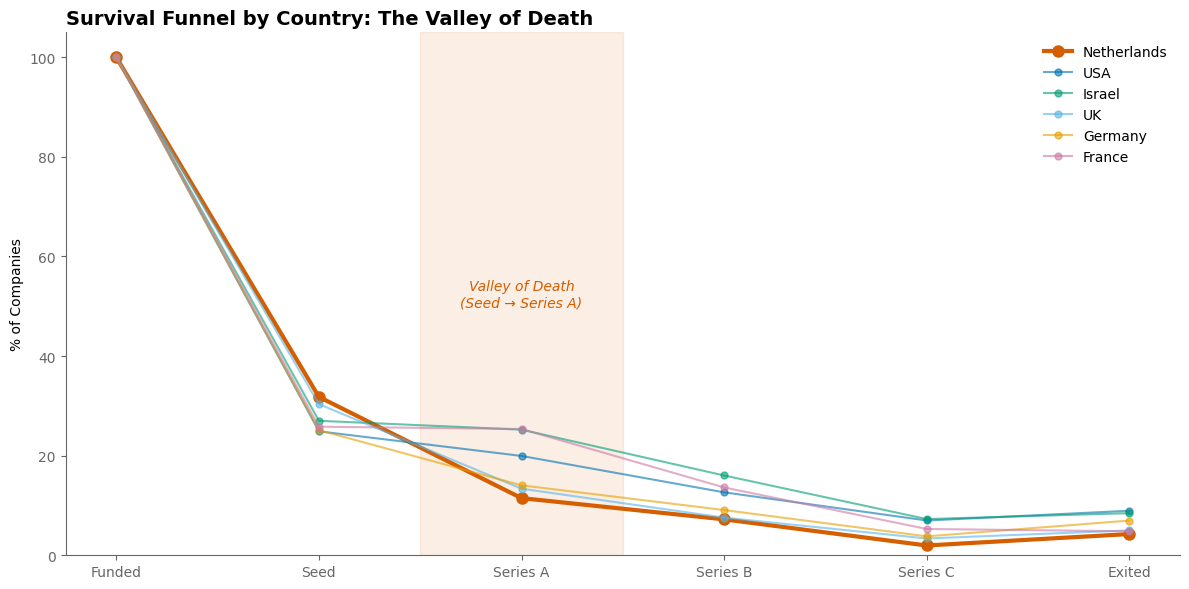


STAGE-TO-STAGE CONVERSION RATES (%)
             Seed→A   A→B  B→Exit
country                          
Netherlands     6.2  22.9    18.2
USA            15.8  37.7    19.5
Israel         21.4  32.9    15.7
UK              8.0  27.0    13.3
Germany        11.8  20.3     8.1
France          9.5  21.3     6.0

KEY INSIGHT: Dutch Seed → Series A conversion is 6.2% vs USA 15.8% and Israel 21.4%


In [4]:
# === PART 4: FUNNEL ANALYSIS ===
# Source: legacy/task-1-analysis/deep_dive_4_survival.ipynb

# Calculate funnel by country
def calculate_funnel(country_code):
    subset = df_filtered[df_filtered['country_code'] == country_code]
    n = len(subset)
    if n == 0:
        return None
    
    return {
        'country': COUNTRIES.get(country_code, country_code),
        'Funded': 100,
        'Seed': subset['had_seed'].sum() / n * 100,
        'Series A': subset['had_series_a'].sum() / n * 100,
        'Series B': subset['had_series_b'].sum() / n * 100,
        'Series C': subset['had_series_c'].sum() / n * 100,
        'Exited': subset['exited'].sum() / n * 100,
        'n': n
    }

funnel_data = [calculate_funnel(c) for c in COUNTRIES.keys()]
funnel_df = pd.DataFrame(funnel_data).set_index('country')

print("FUNDING FUNNEL BY COUNTRY (% reaching each stage)")
print(funnel_df.round(1))

# Visualization: Survival funnel
fig, ax = plt.subplots(figsize=(12, 6))
tufte_style(ax)

stages = ['Funded', 'Seed', 'Series A', 'Series B', 'Series C', 'Exited']
x = np.arange(len(stages))

country_colors = {'Netherlands': COUNTRY_COLORS['nl'], 'USA': COUNTRY_COLORS['usa'], 'Israel': COUNTRY_COLORS['israel'],
                  'UK': COUNTRY_COLORS['uk'], 'Germany': COUNTRY_COLORS['germany'], 'France': COUNTRY_COLORS['france']}

for country in funnel_df.index:
    values = [funnel_df.loc[country, s] for s in stages]
    linewidth = 3 if country == 'Netherlands' else 1.5
    alpha = 1.0 if country == 'Netherlands' else 0.6
    ax.plot(x, values, marker='o', label=country, color=country_colors[country],
            linewidth=linewidth, alpha=alpha, markersize=8 if country == 'Netherlands' else 5)

ax.set_xticks(x)
ax.set_xticklabels(stages)
ax.set_ylabel('% of Companies')
ax.set_title('Survival Funnel by Country: The Valley of Death', fontsize=14, fontweight='bold', loc='left')
ax.legend(loc='upper right', frameon=False)
ax.set_ylim(0, 105)

# Highlight the "Valley of Death"
ax.axvspan(1.5, 2.5, alpha=0.1, color=COUNTRY_COLORS['failure'])
ax.text(2, 50, 'Valley of Death\n(Seed → Series A)', ha='center', fontsize=10, 
        color=COUNTRY_COLORS['failure'], style='italic')

plt.tight_layout()
plt.savefig('figures/survival_funnel.png', dpi=150, bbox_inches='tight')
plt.show()

# Calculate stage-to-stage conversion rates
def conversion_rates(country_code):
    subset = df_filtered[df_filtered['country_code'] == country_code]
    
    with_seed = subset[subset['had_seed']]
    with_a = subset[subset['had_series_a']]
    with_b = subset[subset['had_series_b']]
    
    seed_to_a = with_seed['had_series_a'].sum() / len(with_seed) * 100 if len(with_seed) > 0 else 0
    a_to_b = with_a['had_series_b'].sum() / len(with_a) * 100 if len(with_a) > 0 else 0
    b_to_exit = with_b['exited'].sum() / len(with_b) * 100 if len(with_b) > 0 else 0
    
    return {
        'country': COUNTRIES.get(country_code, country_code),
        'Seed→A': seed_to_a,
        'A→B': a_to_b,
        'B→Exit': b_to_exit
    }

conv_data = [conversion_rates(c) for c in COUNTRIES.keys()]
conv_df = pd.DataFrame(conv_data).set_index('country')

print("\nSTAGE-TO-STAGE CONVERSION RATES (%)")
print(conv_df.round(1))
print("\nKEY INSIGHT: Dutch Seed → Series A conversion is 6.2% vs USA 15.8% and Israel 21.4%")

In [ ]:
# === CHART #1: Full Funding Funnel — Stage-by-Stage Conversion ===
print('CHART #1: Funding Funnel')

def calc_conversion(country_codes, from_col, to_col):
    """Calculate conversion rate from one stage to next."""
    if isinstance(country_codes, str): country_codes = [country_codes]
    subset = df_filtered[df_filtered['country_code'].isin(country_codes)]
    with_from = subset[subset[from_col] > 0]
    if len(with_from) == 0: return 0, 0
    converted = (with_from[to_col] > 0).sum()
    return converted / len(with_from) * 100, len(with_from)

regions = ['Netherlands', 'European Peers\n(UK/DE/FR)', 'USA', 'Israel']
region_codes = [['NLD'], ['GBR', 'DEU', 'FRA'], ['USA'], ['ISR']]
region_colors = ['#D55E00', '#56B4E9', '#0072B2', '#009E73']

transitions = [
    ('Seed → A', 'seed', 'round_A'),
    ('A → B', 'round_A', 'round_B'),
    ('B → C', 'round_B', 'round_C'),
    ('C → D', 'round_C', 'round_D'),
]

fig, ax = plt.subplots(figsize=(14, 8))
tufte_style(ax)

x = np.arange(len(transitions))
width = 0.18

for i, (region, codes, color) in enumerate(zip(regions, region_codes, region_colors)):
    rates_n = [calc_conversion(codes, t[1], t[2]) for t in transitions]
    rates = [r[0] for r in rates_n]
    ns = [r[1] for r in rates_n]
    
    bars = ax.bar(x + (i - 1.5) * width, rates, width, label=region, color=color, alpha=0.9)
    
    # Add labels
    for j, (bar, rate, n) in enumerate(zip(bars, rates, ns)):
        if rate > 0:
            y_pos = bar.get_height() - 3 if bar.get_height() > 10 else bar.get_height() + 1
            txt_color = 'white' if bar.get_height() > 10 else color
            va = 'top' if bar.get_height() > 10 else 'bottom'
            ax.text(bar.get_x() + bar.get_width()/2, y_pos,
                    f'{rate:.1f}%\n(n={n})', ha='center', va=va,
                    fontsize=8, fontweight='bold', color=txt_color)

ax.set_xticks(x)
ax.set_xticklabels([t[0] for t in transitions], fontsize=12)
ax.set_ylabel('Conversion Rate (%)', fontsize=11)
ax.set_ylim(0, 45)

ax.set_title('Full Funding Funnel: Where Do Dutch Startups Lose Ground?', 
             fontweight='bold', loc='left', fontsize=16, pad=15)

# Key insight box - just about the gap, not the scale-up calculation
insight_box = dict(boxstyle='round,pad=0.4', facecolor='#fff3e6', edgecolor='#D55E00', linewidth=2)
ax.text(0.02, 0.95, 
        f'Key Insight: NL gap vs peers is largest\nat Seed→A (-9.6pp) and B→C (-16.6pp)',
        transform=ax.transAxes, fontsize=10, fontweight='bold', color='#8B4513',
        verticalalignment='top', bbox=insight_box)

ax.legend(loc='upper right', frameon=False, fontsize=10)

plt.tight_layout()
plt.savefig('figures/finding1_funding_funnel.png', dpi=150, bbox_inches='tight', transparent=True)
plt.show()

print('✓ Saved to figures/finding1_funding_funnel.png')

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# === 1. DATA CLEANING & PREP ===
# Fix 'funding_total_usd': remove commas/spaces and convert to numeric
df['funding_total_usd'] = (df['funding_total_usd']
                           .astype(str)
                           .str.replace(',', '')
                           .str.replace(' ', '')
                           )
df['funding_total_usd'] = pd.to_numeric(df['funding_total_usd'], errors='coerce')

# Fix 'exited': Create the column based on status
df['exited'] = df['status'].isin(['acquired', 'ipo']).astype(int)

# === CHART #2: Playing It Small — Final Version ===
print('CHART #2: Playing It Small')

def get_metrics(codes):
    subset = df[df['country_code'].isin(codes)]
    n = len(subset)
    if n == 0: return {'failure': 0, 'exit': 0, 'funding': 0, 'n': 0}
    
    failure = (subset['status'] == 'closed').sum() / n * 100
    exit_rate = subset['exited'].sum() / n * 100
    median_funding = subset['funding_total_usd'].median() / 1e6
    if pd.isna(median_funding): median_funding = 0
    
    return {'failure': failure, 'exit': exit_rate, 'funding': median_funding, 'n': n}

regions = ['USA', 'Israel', 'EU Peers', 'Netherlands']
codes = {'USA': ['USA'], 'Israel': ['ISR'], 'EU Peers': ['GBR', 'DEU', 'FRA'], 'Netherlands': ['NLD']}
colors = {'USA': '#0072B2', 'Israel': '#009E73', 'EU Peers': '#888888', 'Netherlands': '#D55E00'}

data = {r: get_metrics(codes[r]) for r in regions}

# === PLOTTING ===
fig = plt.figure(figsize=(15, 10))

fig.text(0.5, 0.95, 'Finding #2: Playing It Small', fontsize=20, fontweight='bold', ha='center')
fig.text(0.5, 0.91, 'Netherlands ranks last on all three dimensions', 
         fontsize=12, ha='center', color='#555555', style='italic')

metrics_config = [
    ('failure', 'Failure rate', '(companies that shut down)', '%', 10),
    ('funding', 'Money raised', '(median funding)', '$M', 5),
    ('exit', 'Exit rate', '(acquired or IPO)', '%', 12),
]

for col_idx, (metric, title, subtitle, unit, max_val) in enumerate(metrics_config):
    ax = fig.add_axes([0.12 + col_idx * 0.29, 0.35, 0.24, 0.45])
    
    sorted_regions = sorted(regions, key=lambda r: data[r][metric], reverse=True)
    
    y_positions = np.arange(len(sorted_regions))
    values = [data[r][metric] for r in sorted_regions]
    bar_colors = [colors[r] for r in sorted_regions]
    
    bars = ax.barh(y_positions, values, color=bar_colors, height=0.55, 
                   edgecolor='white', linewidth=2, alpha=0.85)
    
    for rank, (region, val) in enumerate(zip(sorted_regions, values)):
        if unit == '$M':
            val_str = f'${val:.1f}M'
        else:
            val_str = f'{val:.1f}%'
        
        txt_weight = 'bold' if region == 'Netherlands' else 'normal'
        ax.text(val + max_val * 0.02, rank, val_str, fontsize=10, fontweight=txt_weight,
                va='center', ha='left', color='#333333')
        
        if region == 'Netherlands':
            bars[rank].set_edgecolor('#D55E00')
            bars[rank].set_linewidth(3)
    
    rank_labels = [f'#{rank+1}  {region}' for rank, region in enumerate(sorted_regions)]
    ax.set_yticks(y_positions)
    ax.set_yticklabels(rank_labels, fontsize=10)
    
    for tick, region in zip(ax.get_yticklabels(), sorted_regions):
        if region == 'Netherlands':
            tick.set_fontweight('bold')
            tick.set_color('#D55E00')
    
    ax.invert_yaxis()
    current_max = max(values) if values else 1
    ax.set_xlim(0, current_max * 1.25)
    
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(bottom=False, labelbottom=False)
    
    ax.set_title(f'{title}\n{subtitle}', fontsize=12, fontweight='bold', pad=12)

# Bottom section - THE PATTERN
fig.text(0.5, 0.23, 'THE PATTERN', fontsize=12, fontweight='bold', ha='center', color='#333333')

nl_fail = data['Netherlands']['failure']
nl_fund = data['Netherlands']['funding']
nl_exit = data['Netherlands']['exit']

box_props = dict(boxstyle='round,pad=0.5', facecolor='#fff8f0', edgecolor='#D55E00', linewidth=2)

fig.text(0.18, 0.12, f'Low failure\n({nl_fail:.1f}%)', fontsize=12, ha='center', va='center', 
         bbox=box_props, color='#D55E00', fontweight='bold')
fig.text(0.34, 0.12, '―――', fontsize=14, ha='center', va='center', color='#D55E00', fontweight='bold')
fig.text(0.50, 0.12, f'Low funding\n(${nl_fund:.1f}M)', fontsize=12, ha='center', va='center',
         bbox=box_props, color='#D55E00', fontweight='bold')
fig.text(0.66, 0.12, '―――', fontsize=14, ha='center', va='center', color='#D55E00', fontweight='bold')
fig.text(0.82, 0.12, f'Low exits\n({nl_exit:.1f}%)', fontsize=12, ha='center', va='center',
         bbox=box_props, color='#D55E00', fontweight='bold')

fig.text(0.5, 0.03, 'A consistent pattern: the Dutch ecosystem operates at a smaller scale across all metrics', 
         fontsize=10, ha='center', color='#666666', style='italic')

plt.savefig('figures/finding2_playing_small.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print('✓ Saved to figures/finding2_playing_small.png')

CHART #3: The Opportunity Cost
NL Seed companies: 97
Actual → Series A: 6 (at NL's 6.2% rate)
If EU rate (9.0%): 8 (+2)
If USA rate (15.8%): 15 (+9)
If Israel rate (21.4%): 20 (+14)


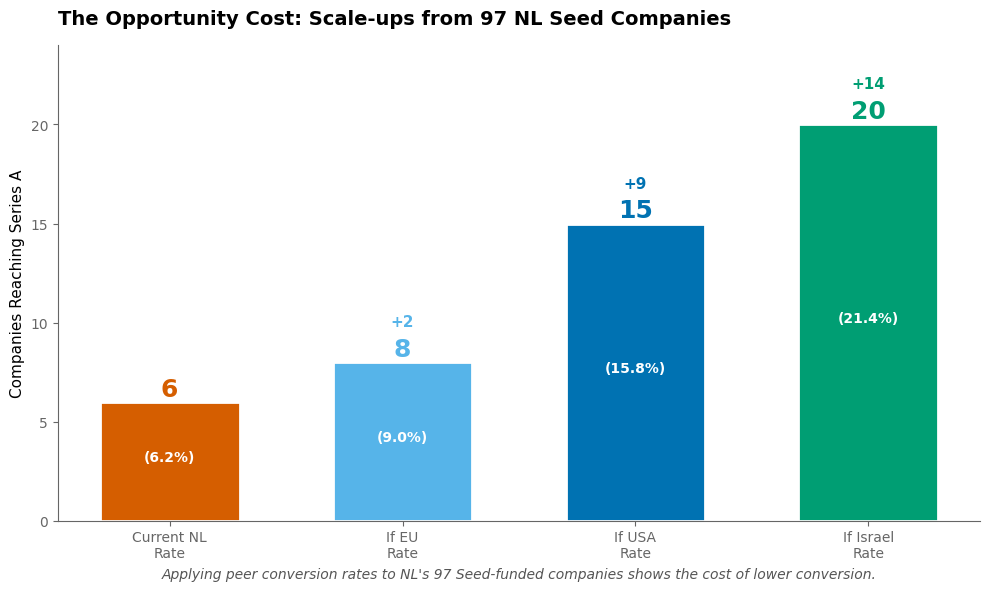

✓ Saved to figures/finding3_opportunity_cost.png


In [7]:
# === CHART #3: The Opportunity Cost — Simple Scale-up Comparison ===
print('CHART #3: The Opportunity Cost')

# Calculate conversion rates
def get_seed_to_a_rate(codes):
    if isinstance(codes, str): codes = [codes]
    subset = df_filtered[df_filtered['country_code'].isin(codes)]
    with_seed = subset[subset['had_seed']]
    to_a = with_seed[with_seed['had_series_a']].shape[0]
    n = len(with_seed)
    return to_a / n * 100 if n > 0 else 0, n

nl_rate, nl_n = get_seed_to_a_rate('NLD')
eu_rate, _ = get_seed_to_a_rate(['GBR', 'DEU', 'FRA'])
usa_rate, _ = get_seed_to_a_rate('USA')
israel_rate, _ = get_seed_to_a_rate('ISR')

# Scale-ups at each rate (applying peer rates to NL's 97 Seed companies)
nl_actual = int(nl_n * nl_rate / 100)
nl_at_eu = int(nl_n * eu_rate / 100)
nl_at_usa = int(nl_n * usa_rate / 100)
nl_at_israel = int(nl_n * israel_rate / 100)

print(f"NL Seed companies: {nl_n}")
print(f"Actual → Series A: {nl_actual} (at NL's {nl_rate:.1f}% rate)")
print(f"If EU rate ({eu_rate:.1f}%): {nl_at_eu} (+{nl_at_eu - nl_actual})")
print(f"If USA rate ({usa_rate:.1f}%): {nl_at_usa} (+{nl_at_usa - nl_actual})")
print(f"If Israel rate ({israel_rate:.1f}%): {nl_at_israel} (+{nl_at_israel - nl_actual})")

# Simple bar chart - just the scale-up counts
fig, ax = plt.subplots(figsize=(10, 6))
tufte_style(ax)

scenarios = ['Current NL\nRate', 'If EU\nRate', 'If USA\nRate', 'If Israel\nRate']
scaleups = [nl_actual, nl_at_eu, nl_at_usa, nl_at_israel]
rates = [nl_rate, eu_rate, usa_rate, israel_rate]
colors = ['#D55E00', '#56B4E9', '#0072B2', '#009E73']

x = np.arange(len(scenarios))
bars = ax.bar(x, scaleups, color=colors, width=0.6, edgecolor='white', linewidth=2)

# Labels
for i, (bar, count, rate) in enumerate(zip(bars, scaleups, rates)):
    # Count on bar
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.3,
            f'{count}', fontsize=18, fontweight='bold', ha='center', color=colors[i])
    # Rate in bar
    ax.text(bar.get_x() + bar.get_width()/2, bar.get_height()/2,
            f'({rate:.1f}%)', fontsize=10, ha='center', color='white', fontweight='bold')
    # Extra annotation
    if i > 0:
        extra = count - nl_actual
        ax.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 1.8,
                f'+{extra}', fontsize=11, ha='center', color=colors[i], fontweight='bold')

ax.set_xticks(x)
ax.set_xticklabels(scenarios, fontsize=10)
ax.set_ylabel('Companies Reaching Series A', fontsize=11)
ax.set_ylim(0, max(scaleups) + 4)

ax.set_title(f'The Opportunity Cost: Scale-ups from {nl_n} NL Seed Companies', 
             fontweight='bold', loc='left', fontsize=14, pad=15)

# Bottom text
ax.text(0.5, -0.12, 
        f'Applying peer conversion rates to NL\'s {nl_n} Seed-funded companies shows the cost of lower conversion.',
        transform=ax.transAxes, fontsize=10, ha='center', color='#555', style='italic')

plt.tight_layout()
plt.savefig('figures/finding3_opportunity_cost.png', dpi=150, bbox_inches='tight', facecolor='white')
plt.show()

print('✓ Saved to figures/finding3_opportunity_cost.png')

In [8]:
# === POLICY RECOMMENDATIONS ===
"""
POLICY RECOMMENDATIONS — Based on Data Analysis + International Benchmarking

════════════════════════════════════════════════════════════════════════════════
THE PROBLEM (from our analysis)
════════════════════════════════════════════════════════════════════════════════
• NL Seed→A conversion: 6.2% vs USA 16% vs Israel 21%
• Result: ~9 fewer scale-ups per cohort
• Pattern: Playing it small (less capital, fewer rounds)

════════════════════════════════════════════════════════════════════════════════
WHAT WORKS: PROVEN INTERNATIONAL MODELS
════════════════════════════════════════════════════════════════════════════════

1. ISRAEL — YOZMA PROGRAM (1993-1998)
   ─────────────────────────────────────────────────────────────────────────────
   STRUCTURE:
   • $100M government investment into 10 new VC funds ($20M each)
   • Required foreign VC partner (expertise transfer mechanism)
   • Government took 40% stake; private partners had buyout option

   RESULTS:
   • VC investment grew 60x: $58M (1991) → $3.3B (2000)
   • 6 of 10 funds achieved >100% IRR
   • 9 of 10 funds bought out government stake → fully privatized
   • 2,000+ startups created; $10B+ total VC capital raised
   • Israel now 2nd globally in VC/GDP ratio

   WHY IT WORKED:
   • Foreign VCs brought networks + deal flow expertise
   • Buyout option aligned incentives → funds succeeded to buy out
   • Government exited → self-sustaining private ecosystem

2. USA — SBIC/SBIR PROGRAMS (Since 1958/1982)
   ─────────────────────────────────────────────────────────────────────────────
   STRUCTURE:
   • SBIC: Government-guaranteed loans to private VC funds (2:1 leverage)
   • SBIR: $200M+/year in non-dilutive grants through federal agencies
   • Government follows private capital, doesn't pick winners

   RESULTS (FY2025):
   • $53B combined private capital + SBA leverage (record year)
   • 48 new SBIC licenses approved → $14B expected investment
   • 130,000+ jobs created/sustained annually
   • Over $100B deployed through combined programs

   STATE-LEVEL MODEL (MassVentures, founded 1978):
   • 400+ companies funded
   • $5B+ in private capital leveraged from state investment
   • START program: $100K-$500K non-dilutive matching grants

   WHY IT WORKED:
   • Government de-risks, private sector decides
   • Leverage model multiplies impact
   • Non-dilutive grants cover gaps federal R&D won't fund

3. UK — SEIS/EIS TAX RELIEF (Since 1994)
   ─────────────────────────────────────────────────────────────────────────────
   STRUCTURE:
   • SEIS: 50% income tax relief on investments up to £200K/year
   • EIS: 30% relief on investments up to £1M/year
   • Capital gains exemption if held 3+ years

   RESULTS:
   • 90%+ of UK angel investments now use SEIS/EIS
   • Made early-stage investing rational (risk mitigation built-in)

   WHY IT WORKED:
   • Directly addresses the risk/reward calculation for angels
   • Simple, predictable, scales with private investment

════════════════════════════════════════════════════════════════════════════════
RECOMMENDATIONS FOR NETHERLANDS (2-3 Key Actions)
════════════════════════════════════════════════════════════════════════════════

┌─────────────────────────────────────────────────────────────────────────────┐
│ 1. YOZMA-STYLE PROGRAM: Bridge the Valley of Death                         │
├─────────────────────────────────────────────────────────────────────────────┤
│ WHAT: €100M fund-of-funds requiring international VC partners               │
│ HOW:  Government takes 40% stake, private partners can buy out             │
│ WHY:  Israel's model brought expertise + networks, not just capital        │
│                                                                             │
│ EXPECTED IMPACT: If NL matches USA's 16% Seed→A rate, +9 scale-ups/year   │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│ 2. DUTCH SEIS: Make Angel Investing Rational                               │
├─────────────────────────────────────────────────────────────────────────────┤
│ WHAT: 30-50% tax relief on seed investments up to €200K/year               │
│ HOW:  Mirror UK SEIS structure; add capital gains exemption (3+ years)     │
│ WHY:  Currently high-risk = irrational; tax relief = risk mitigation       │
│                                                                             │
│ EXPECTED IMPACT: UK's 90%+ angel adoption shows demand exists              │
└─────────────────────────────────────────────────────────────────────────────┘

┌─────────────────────────────────────────────────────────────────────────────┐
│ 3. SBIC-STYLE LEVERAGE: Multiply Private Capital                           │
├─────────────────────────────────────────────────────────────────────────────┤
│ WHAT: Government-guaranteed loans to VC funds (1:1 or 2:1 leverage)        │
│ HOW:  Mirror USA's SBIC structure; let private VCs select investments      │
│ WHY:  USA deployed $53B in FY25; multiplies impact of public capital       │
│                                                                             │
│ EXPECTED IMPACT: MassVentures leveraged $5B from modest state investment   │
└─────────────────────────────────────────────────────────────────────────────┘

════════════════════════════════════════════════════════════════════════════════
KEY INSIGHT
════════════════════════════════════════════════════════════════════════════════
The problem isn't Dutch founders — they perform equally well at Series B+.
The problem is the BOTTLENECK at Seed→A.

Israel fixed it with Yozma. The USA scaled it with SBIC.
The Netherlands can do both.
"""

print("POLICY RECOMMENDATIONS")
print("=" * 70)
print("""
PROVEN MODELS:

1. ISRAEL YOZMA (1993): $100M → 60x VC growth in 7 years
   • Required foreign VC partners (expertise transfer)
   • 9/10 funds bought out government stake → fully privatized
   • Result: Israel now #2 globally in VC/GDP ratio

2. USA SBIC/SBIR: $53B deployed in FY2025 alone
   • Government leverage multiplies private capital 2:1
   • MassVentures: $5B private capital from state investment
   • 130,000+ jobs created annually

3. UK SEIS: 90%+ of angel investments now use it
   • 50% tax relief makes early-stage investing rational
   • Simple structure, scales with private investment

RECOMMENDED ACTIONS:

1. Yozma-style fund-of-funds (€100M, require foreign VC partners)
2. Dutch SEIS (30-50% tax relief on seed investments)
3. SBIC-style leverage (government-guaranteed loans to VCs)

TARGET: Improve Seed→A conversion from 6% to 15% = +9 scale-ups/year
""")
print("=" * 70)
print("\nKey Insight: The problem isn't Dutch founders — it's the bottleneck.")
print("Israel and the USA fixed it. The Netherlands can too.")

POLICY RECOMMENDATIONS

PROVEN MODELS:

1. ISRAEL YOZMA (1993): $100M → 60x VC growth in 7 years
   • Required foreign VC partners (expertise transfer)
   • 9/10 funds bought out government stake → fully privatized
   • Result: Israel now #2 globally in VC/GDP ratio

2. USA SBIC/SBIR: $53B deployed in FY2025 alone
   • Government leverage multiplies private capital 2:1
   • MassVentures: $5B private capital from state investment
   • 130,000+ jobs created annually

3. UK SEIS: 90%+ of angel investments now use it
   • 50% tax relief makes early-stage investing rational
   • Simple structure, scales with private investment

RECOMMENDED ACTIONS:

1. Yozma-style fund-of-funds (€100M, require foreign VC partners)
2. Dutch SEIS (30-50% tax relief on seed investments)
3. SBIC-style leverage (government-guaranteed loans to VCs)

TARGET: Improve Seed→A conversion from 6% to 15% = +9 scale-ups/year


Key Insight: The problem isn't Dutch founders — it's the bottleneck.
Israel and the USA fixed i